In [254]:
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt
import torch

path = '/home/nina/CopulaGP/results'

with open(f"{path}/figure3c.pkl","rb") as f:
    data = pkl.load(f)
assert np.all(data['X']==data['Xs'])

(3353, 2) (400, 2)
[0.01       0.01128838 0.01274275 0.0143845  0.01623777 0.01832981
 0.02069138 0.02335721 0.02636651 0.02976351 0.03359818 0.0379269
 0.04281332 0.0483293  0.05455595 0.06158482 0.06951928 0.078476
 0.08858668 0.1       ]
CPU times: user 7.84 s, sys: 0 ns, total: 7.84 s
Wall time: 7.84 s


{'bandwidth': 0.0379269019073225}

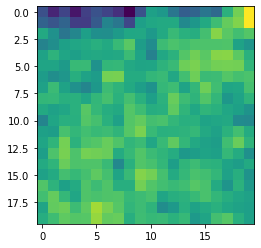

In [258]:
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV, LeaveOneOut, KFold

# this mask selects a zone in the VR corridor
mask = (data['X']>140/160) & (data['X']<=160/160)
x = data['Y'].squeeze()[mask]
# print(x.shape)

kde = KernelDensity(bandwidth=.025, kernel='gaussian')
kde.fit(x)

N = 20
x_d = (np.mgrid[0:N,0:N]+1)/(N+2)
x_d = (x_d.reshape(2,-1)).T
print(x.shape,x_d.shape)

# score_samples returns the log of the probability density
logprob = kde.score_samples(x_d)
plt.imshow(logprob.reshape(N,N))

bandwidths = 10 ** np.linspace(-2, -1, 20)
print(bandwidths)
grid = GridSearchCV(KernelDensity(kernel='gaussian'),
                    {'bandwidth': bandwidths},
                    cv=KFold(n_splits=5))
%time grid.fit(x);
grid.best_params_

In [259]:
# from https://github.com/napsternxg/pytorch-practice/blob/master/Pytorch%20-%20MMD%20VAE.ipynb
l = grid.best_params_['bandwidth']
def compute_kernel(x, y):
    alpha = 1/(l)**2
    x_size = x.size(0)
    y_size = y.size(0)
    dim = x.size(1)
    x = x.unsqueeze(1) # (x_size, 1, dim)
    y = y.unsqueeze(0) # (1, y_size, dim)
    tiled_x = x.expand(x_size, y_size, dim)
    tiled_y = y.expand(x_size, y_size, dim)
    kernel_input = (tiled_x - tiled_y).pow(2).mean(2)/float(dim) # i think there is no need to divide by dim here
    return torch.exp(-alpha*kernel_input) # (x_size, y_size)

def compute_mmd(x, y):
    x_kernel = compute_kernel(x, x)
    y_kernel = compute_kernel(y, y)
    xy_kernel = compute_kernel(x, y)
    mmd = x_kernel.mean() + y_kernel.mean() - 2*xy_kernel.mean()
    return mmd

def compute_witness(x,y,grid):
    x_kernel = compute_kernel(x, grid)
    y_kernel = compute_kernel(y, grid)
    witness = x_kernel.mean(axis=0) - y_kernel.mean(axis=0)
    return witness


compute_mmd(torch.tensor(data['Y'][mask]),torch.tensor(data['Ys'].squeeze()[mask]))*1e3

tensor(1.2338, dtype=torch.float64)

In [245]:
# dx = y2[y2[:,1]>1-0.03,0].mean()-y1[y1[:,1]>1-0.03,0].mean()
# dy = y2[y2[:,0]<0.03,1].mean()-y1[y1[:,0]<0.03,1].mean()
# (dx,dy)
# y2[:,1].mean()-y1[:,1].mean()

In [314]:
# if we want to shuffle real vs. synthetic for precisely the same position in VR
y1 = torch.tensor(data['Y'][mask]-np.array([0.019,0.0037]))
y2 = torch.tensor(data['Ys'].squeeze()[mask])
# y1 = (y1-y1.min())/(y1.max()-y1.min())
# y2 = (y2-y2.min())/(y2.max()-y2.min())
# y1 = (y1-y1.mean(0))/y1.std(0)
# y2 = (y2-y2.mean(0))/y2.std(0)
size = y1.shape[0]
choice = np.random.random(size)>0.5
y1_ = np.concatenate([y1[np.where(choice==True)],y2[np.where(choice==False)]])
y2_ = np.concatenate([y1[np.where(choice==False)],y2[np.where(choice==True)]])
# plt.figure(figsize=(3,3))
# # plt.scatter(*data['Ys'].squeeze()[mask].T,alpha=0.01)
# plt.scatter(*y1.T,alpha=0.02)
# plt.scatter(*y2.T,alpha=0.02)
compute_mmd(y1,y2)*1000

tensor(1.0977, dtype=torch.float64)

In [315]:
y = np.concatenate([y1,y2])
perm = 100 # 1000 should take 10 min
def mmds(y,size,p=perm):
    mmds = []
    for i in range(p):
        if i%(perm//10)==0:
            print(i//(perm//10))
#         # we can shuffle all samples within the zone
        np.random.shuffle(y)
        mmd = compute_mmd(torch.tensor(y[:size]),torch.tensor(y[size:]))
        # or, alternatively, only swap real vs. synthetic data
#         choice = np.random.random(size)>0.5
#         y1_ = np.concatenate([y1[np.where(choice==True)],y2[np.where(choice==False)]])
#         y2_ = np.concatenate([y1[np.where(choice==False)],y2[np.where(choice==True)]])
#         mmd = compute_mmd(torch.tensor(y1_),torch.tensor(y2_))
        mmds.append(mmd)
    return mmds
%time mmds = mmds(y,size)
true_mmd = compute_mmd(y1,y2)

0
1
2
3
4
5
6
7
8
9
CPU times: user 9min 19s, sys: 7min 34s, total: 16min 53s
Wall time: 32.3 s


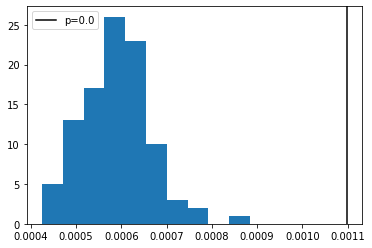

In [316]:
plt.hist(mmds)
plt.axvline(true_mmd,color='k',label = f'p={((np.array(mmds)>=true_mmd.numpy()).sum())/perm}')
plt.legend()

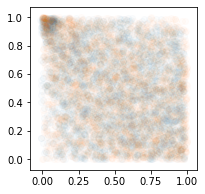

In [317]:
plt.figure(figsize=(3,3))
# plt.scatter(*data['Ys'].squeeze()[mask].T,alpha=0.01)
plt.scatter(*y1.T,alpha=0.02)
plt.scatter(*y2.T,alpha=0.02)
# x_d

tensor(0.0090, dtype=torch.float64) tensor(-0.0111, dtype=torch.float64)


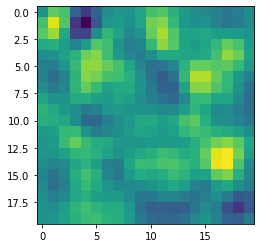

In [318]:
N = 20
x_d = (np.mgrid[0:N,0:N])/(N-1)
x_d = (x_d.reshape(2,-1)).T
witness = compute_witness(y1,y2,torch.tensor(x_d)).reshape(N,N)
plt.imshow(np.flip(witness.numpy().T,axis=0))
print(witness.max(),witness.min())

In [77]:
# Maybe we can apply MMD to norm plots instead of copulas? I think the value will improve a lot. 
# Now if the tail is slightly not in the corner (due to inaccuracy of empirical CDF transform), then the score is poor.
# Which does not really mean that copula fit is bad.